# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




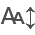

In [91]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [92]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [93]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [94]:
## define SPARQL enpoint
endpoint = "https://ag1khc5dnlqgdc0c.allegrograph.cloud/repositories/Astronauts"

In [95]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/projhistoire/Projet-Histoire/blob/main/Wikidata/graph/imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [96]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [97]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

867


[['http://www.wikidata.org/entity/Q118185981',
  'Anastasia Lenkova',
  '1995',
  'female',
  'Belarus',
  'Europe',
  '',
  ''],
 ['http://www.wikidata.org/entity/Q268912',
  'Mary Ellen Weber',
  '1962',
  'female',
  'United States',
  'North America',
  '',
  ''],
 ['http://www.wikidata.org/entity/Q56725368',
  'Hazza Al Mansouri',
  '1983',
  'male',
  'United Arab Emirates',
  'Asia',
  '',
  '']]

In [98]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,


In [99]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [100]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    867 non-null    object
 1   personLabel  867 non-null    object
 2   birthYear    867 non-null    int64 
 3   gender       867 non-null    object
 4   countries    867 non-null    object
 5   continents   867 non-null    object
 6   occupations  867 non-null    object
 7   fields       867 non-null    object
dtypes: int64(1), object(7)
memory usage: 54.3+ KB


In [101]:
### Store to CSV
f_path = 'data/df_continent_occupations_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [102]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0           Europe
1    North America
2             Asia
3             Asia
4           Europe
Name: continents, dtype: object


In [103]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                        0
continents                               
North America                         448
Europe                                171
Asia                                   81
Asia, Europe                           74
Europe, Asia                           56
North America, Europe                  12
North America, Asia                     4
South America                           3
Asia, Europe, North America, Eurasia    2
Africa                                  2


In [104]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [105]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [106]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia


In [107]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
SouthAmerica         3
Africa               4
Oceania              5
Eurasia             56
Asia                81
Europe             264
NorthAmerica       454


In [108]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
5,http://www.wikidata.org/entity/Q3501233,Konstantin Valkov,1971,male,Russia,Europe,,,Europe
7,http://www.wikidata.org/entity/Q555679,Aleksandr Skvortsov,1966,male,Russia,Europe,,,Europe
20,http://www.wikidata.org/entity/Q13519676,Nikolai Tikhonov,1982,male,Russia,Europe,,,Europe
21,http://www.wikidata.org/entity/Q709634,Valery Korzun,1953,male,Russia,Europe,,,Europe
29,http://www.wikidata.org/entity/Q708489,Yury Onufriyenko,1961,male,"Russia, Ukraine",Europe,,,Europe
39,http://www.wikidata.org/entity/Q465724,Anatoly Berezovoy,1942,male,"Russia, Soviet Union","Europe, Asia",,,Eurasia
41,http://www.wikidata.org/entity/Q975217,Sergey Revin,1966,male,Russia,Europe,,,Europe


In [109]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia         52
Europe         119


In [110]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q472491,Gennadi Sarafanov,1942,male,Soviet Union,"Asia, Europe",,,Europe
98,http://www.wikidata.org/entity/Q74015,Dorothy M. Metcalf-Lindenburger,1975,female,United States,North America,,,NorthAmerica
99,http://www.wikidata.org/entity/Q29618,Bonnie J. Dunbar,1949,female,United States,North America,,,NorthAmerica
100,http://www.wikidata.org/entity/Q728371,Vasily Tsibliyev,1954,male,Russia,Europe,,,Europe


In [111]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q528943,Guion Bluford,1942,male,United States,North America,,,NorthAmerica
112,http://www.wikidata.org/entity/Q318934,Joseph M. Acaba,1967,male,United States,North America,,,NorthAmerica
113,http://www.wikidata.org/entity/Q28540326,Matthias Maurer,1970,male,Germany,Europe,,,Europe
114,http://www.wikidata.org/entity/Q63594,Bùi Thanh Liêm,1949,male,Vietnam,Asia,,,Asia
115,http://www.wikidata.org/entity/Q41632,Marsha Ivins,1951,female,United States,North America,,,NorthAmerica
116,http://www.wikidata.org/entity/Q29650,Charles O. Hobaugh,1961,male,United States,North America,,,NorthAmerica
117,http://www.wikidata.org/entity/Q265261,Janet L. Kavandi,1959,female,United States,North America,,,NorthAmerica


In [112]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  867 

0    http://www.wikidata.org/entity/Q118185981
1       http://www.wikidata.org/entity/Q268912
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe


### Distribution des continents: représentation graphique

In [113]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
SouthAmerica,3,0.35
Africa,4,0.46
Oceania,5,0.58
Eurasia,56,6.46
Asia,81,9.34
Europe,264,30.45
NorthAmerica,454,52.36


In [114]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,NorthAmerica,Europe,Asia,Eurasia,Oceania,Africa,SouthAmerica
frequence,52.36,30.45,9.34,6.46,0.58,0.46,0.35


In [115]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


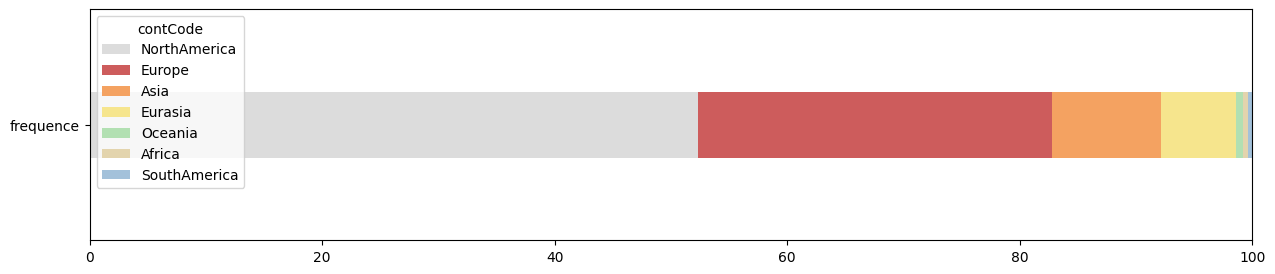

In [116]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [117]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1900, 2050, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1900, 1925, 1950, 1975, 2000] [1925, 1950, 1975, 2000, 2025] 5


In [118]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [119]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999


In [120]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1900-1924     34
1925-1949    311
1950-1974    386
1975-1999    133
2000-2024      3
dtype: int64


### Comparer période et continent

In [121]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,0,0,2,21,11,0,0,34
1925-1949,1,9,37,90,172,2,0,311
1950-1974,2,34,17,101,227,2,3,386
1975-1999,1,36,0,52,43,1,0,133
2000-2024,0,2,0,0,1,0,0,3
Total,4,81,56,264,454,5,3,867


In [122]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,21,2,11,0,0,0,0,34
1925-1949,90,37,172,9,1,2,0,311
1950-1974,101,17,227,34,2,2,3,386
1975-1999,52,0,43,36,1,1,0,133
2000-2024,0,0,1,2,0,0,0,3
Total,264,56,454,81,4,5,3,867


In [123]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


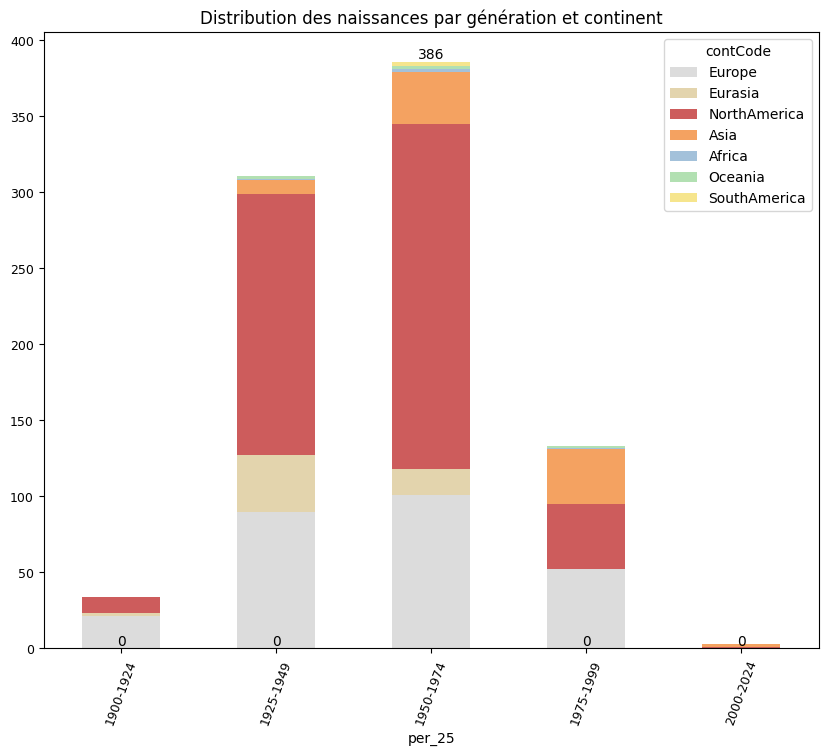

In [124]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [125]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,21,2,11,0,0,0,0,34
1925-1949,90,37,172,9,1,2,0,311
1950-1974,101,17,227,34,2,2,3,386
1975-1999,52,0,43,36,1,1,0,133
2000-2024,0,0,1,2,0,0,0,3
Total,264,56,454,81,4,5,3,867


In [126]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[:-1,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1900-1924,21,2,11,0,0,0,0
1925-1949,90,37,172,9,1,2,0
1950-1974,101,17,227,34,2,2,3
1975-1999,52,0,43,36,1,1,0
2000-2024,0,0,1,2,0,0,0


In [127]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 7 ), effectif: 867 , nombre max. facteurs: 4


In [128]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 136.89 , dof : 24
p-value : 8.65998921146506e-18
phi2 = inertie (variance totale) : 0.1578861218381147
Cramer:  0.19867443333133902


In [129]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1900-1924,10,2,18,3,0,0,0
1925-1949,95,20,163,29,1,2,1
1950-1974,118,25,202,36,2,2,1
1975-1999,40,9,70,12,1,1,0
2000-2024,1,0,2,0,0,0,0


In [130]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1900-1924,21,2,11,0,0,0,0
1925-1949,90,37,172,9,1,2,0
1950-1974,101,17,227,34,2,2,3
1975-1999,52,0,43,36,1,1,0
2000-2024,0,0,1,2,0,0,0


In [131]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1900-1924      11        0            -7    -3       0        0             0
1925-1949      -5       17             9   -20       0        0            -1
1950-1974     -17       -8            25    -2       0        0             2
1975-1999      12       -9           -27    24       0        0             0
2000-2024      -1        0            -1     2       0        0             0


In [132]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1900-1924,3.31,-0.13,-1.61,-1.78,-0.40,-0.44,-0.34
1925-1949,-0.48,3.77,0.72,-3.72,-0.36,0.15,-1.04
1950-1974,-1.53,-1.59,1.75,-0.34,0.16,-0.15,1.44
1975-1999,1.81,-2.93,-3.19,6.69,0.49,0.27,-0.68
2000-2024,-0.96,-0.44,-0.46,3.25,-0.12,-0.13,-0.10


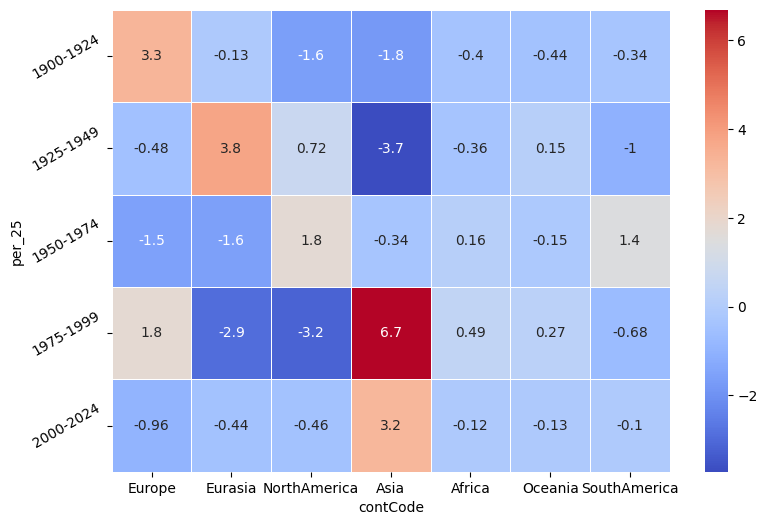

In [133]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [134]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1900-1924,2,11,0,0,0,0
1925-1949,37,172,9,1,2,0
1950-1974,17,227,34,2,2,3
1975-1999,0,43,36,1,1,0
2000-2024,0,1,2,0,0,0


In [135]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 117.33 , dof : 20
p-value : 8.882574058940798e-16
phi2 = inertie (variance totale) : 0.13532897415287878
Cramer:  0.2205546872374636


In [136]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1900-1924,21,0,2,11,0
1925-1949,90,9,37,172,0
1950-1974,101,34,17,227,3
1975-1999,52,36,0,43,0
2000-2024,0,2,0,1,0


In [137]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

ValueError: The internally computed table of expected frequencies has a zero element at (4, 0).

## Continent et genre

In [138]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974


In [139]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,0,13,3,26,75,0,0,117
male,4,68,53,238,379,5,3,750
Total,4,81,56,264,454,5,3,867


### Créer la fonction

In [140]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [141]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,0,13,3,26,75,0,0
male,4,68,53,238,379,5,3


Chi2 : 12.07 , dof : 6
p-value : 0.06048809746058495
phi2 = inertie (variance totale) : 0.013918245979348933
Cramer:  0.11797561603716648


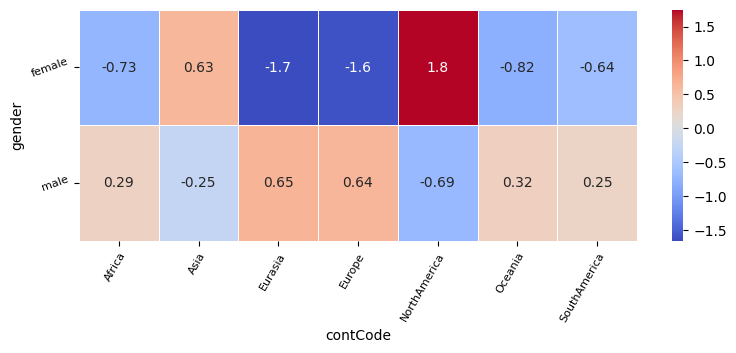

In [142]:
bivariee_stats(D)

### Genre et continent par époque

In [143]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999,Asia_male
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974,Asia_male
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974,Europe_female


In [144]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_male,SouthAmerica_male,Total
per_25,,,,,,,,,,,,
1900-1924,0,0,0,0,2,0,21,0,11,0,0,34
1925-1949,1,0,9,2,35,6,84,11,161,2,0,311
1950-1974,2,5,29,1,16,6,95,43,184,2,3,386
1975-1999,1,8,28,0,0,14,38,21,22,1,0,133
2000-2024,0,0,2,0,0,0,0,0,1,0,0,3
Total,4,13,68,3,53,26,238,75,379,5,3,867


In [145]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[:-1,:-1].copy(deep=True)
D


genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_male,SouthAmerica_male
per_25,,,,,,,,,,,
1900-1924,0,0,0,0,2,0,21,0,11,0,0
1925-1949,1,0,9,2,35,6,84,11,161,2,0
1950-1974,2,5,29,1,16,6,95,43,184,2,3
1975-1999,1,8,28,0,0,14,38,21,22,1,0
2000-2024,0,0,2,0,0,0,0,0,1,0,0


Chi2 : 208.46 , dof : 40
p-value : 1.1918184390787352e-24
phi2 = inertie (variance totale) : 0.240440497771871
Cramer:  0.2451736618051942


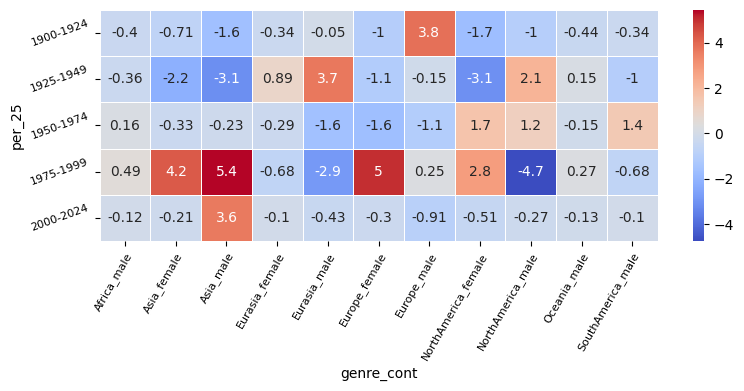

In [146]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [147]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

26


In [148]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
Soviet Union, Russia                             7
Germany                                          3
Russia                                           3
United Kingdom                                   2
France                                           2
Austria                                          1
Belarus                                          1
Belgium                                          1
Australia, Italy, United Kingdom, New Zealand    1
Italy                                            1
dtype: int64


In [149]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

Series([], dtype: int64)


In [150]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

0


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont


## Continent et discipline

In [151]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999,Asia_male
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974,Asia_male
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974,Europe_female


In [152]:
def code_discipline(col1, col2):
    if  'astronomer' in col1\
        or 'astronomy' in col2:
        output = 'astronomy'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [153]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female,other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female,other
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999,Asia_male,other
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974,Asia_male,other
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974,Europe_female,other


In [154]:
df_p.groupby('code_discipline').size()

code_discipline
other    867
dtype: int64

In [155]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
other,4,81,56,264,454,5,3,867
Total,4,81,56,264,454,5,3,867


In [156]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
other,0.5,9.3,6.5,30.4,52.4,0.6,0.3,100.0
Total,0.5,9.3,6.5,30.4,52.4,0.6,0.3,100.0


In [157]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


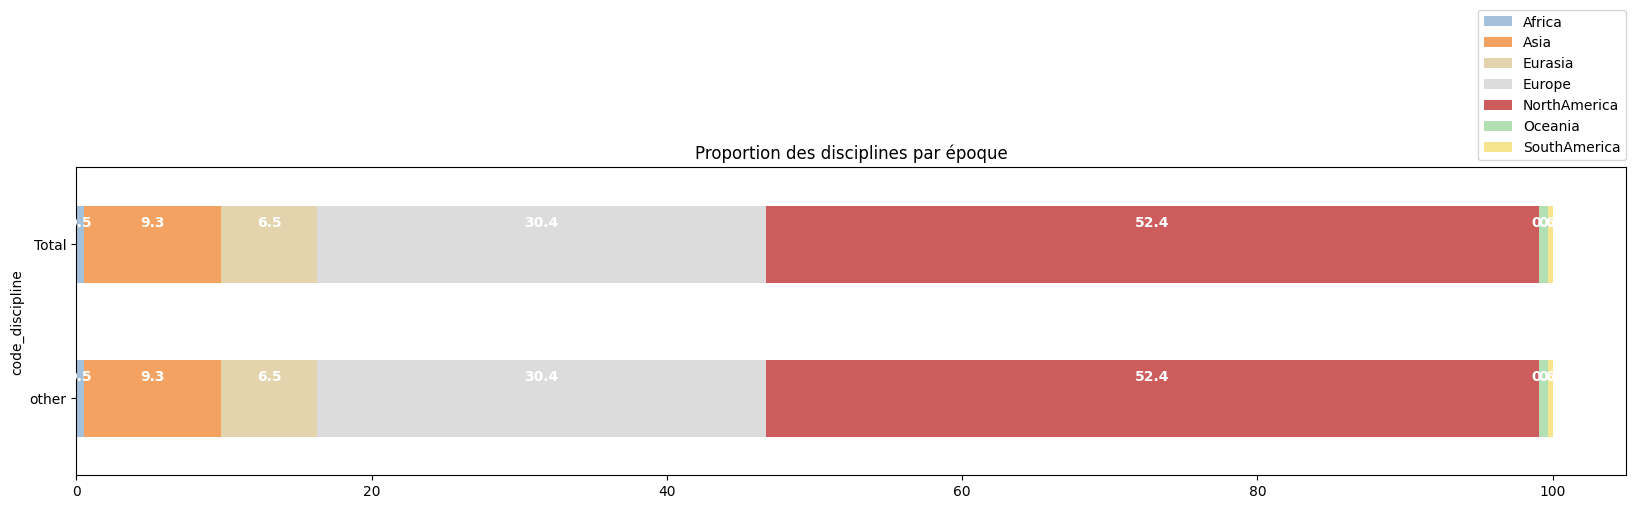

In [158]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [159]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
other,4,81,56,264,454,5,3


In [160]:
## Appliquer la fonction
bivariee_stats(D)

AttributeError: 'float' object has no attribute 'round'

## Discipline et continent par époque

In [161]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female,other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female,other


In [162]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female,other,Europe_other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female,other,NorthAmerica_other


In [163]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_other,Asia_other,Eurasia_other,Europe_other,NorthAmerica_other,Oceania_other,SouthAmerica_other,Total
per_25,,,,,,,,
1900-1924,0,0,2,21,11,0,0,34
1925-1949,1,9,37,90,172,2,0,311
1950-1974,2,34,17,101,227,2,3,386
1975-1999,1,36,0,52,43,1,0,133
2000-2024,0,2,0,0,1,0,0,3
Total,4,81,56,264,454,5,3,867


In [164]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[:-1,:-1].copy(deep=True)
D


disc_cont,Africa_other,Asia_other,Eurasia_other,Europe_other,NorthAmerica_other,Oceania_other,SouthAmerica_other
per_25,,,,,,,
1900-1924,0,0,2,21,11,0,0
1925-1949,1,9,37,90,172,2,0
1950-1974,2,34,17,101,227,2,3
1975-1999,1,36,0,52,43,1,0
2000-2024,0,2,0,0,1,0,0


Chi2 : 136.89 , dof : 24
p-value : 8.659989211464807e-18
phi2 = inertie (variance totale) : 0.15788612183811476
Cramer:  0.19867443333133905


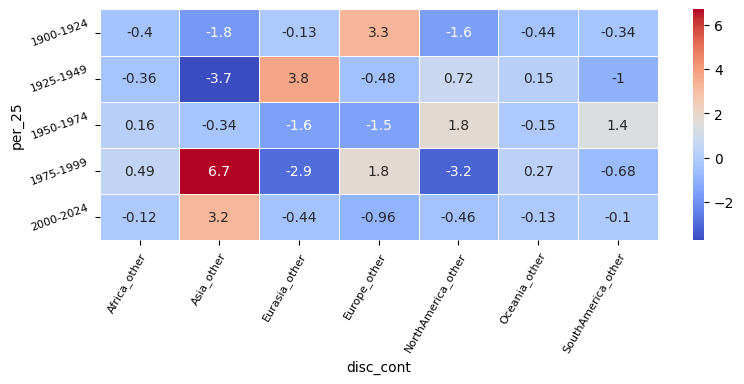

In [165]:
## Appliquer la fonction
bivariee_stats(D)